In [26]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [27]:
# ==========================================
# ⚙️ CONFIGURATION (ปรับจูนตรงนี้)
# ==========================================

# Path ของไฟล์ (แก้ให้ตรงกับเครื่องที่คุณรัน Notebook)
# ถ้า Run บนเครื่องตัวเอง (Windows) ให้แก้ Path เป็น C:/...
TRAFFY_PATH = "../Data/clean/bankok_traffy_clean.csv" 
CONDO_DIR = "../Data/clean"
OUTPUT_DIR = "../Data/score"

# 🎯 Parameter การคิดคะแนน
RADIUS_KM = 1.0           # รัศมีรอบคอนโดที่จะนำมาคิด (km)
BASE_SCORE = 1.0          # คะแนนเต็มเริ่มต้น

# ⚖️ Weight (น้ำหนักการหักคะแนน)
W_UNFINISHED = 0.05       # งานไม่เสร็จ (หักหนัก)
W_FINISHED_BAD = 0.01     # งานเสร็จแต่ดาวน้อย (<3 ดาว)
W_FINISHED_GOOD = 0.001   # งานเสร็จและดี (หักนิดเดียว เป็นแค่ Noise)

# 💥 Multiplier สำหรับเคสหนักๆ
# KEYWORD_MULTIPLIER = 2.0  # ถ้าเจอคำว่า "น้ำท่วม", "ความปลอดภัย" ให้คูณความแรง 2 เท่า

# print(f"⚙️ Config Loaded: Radius={RADIUS_KM}km | Penalty Unfinished={W_UNFINISHED}")

In [28]:
from typing import Dict

TYPE_TO_CATEGORY: Dict[str, str] = {
    # ---- ROAD / TRAVEL ----
    "ถนน": "road",
    "ทางเท้า": "road",
    "จราจร": "road",
    "การเดินทาง": "road",
    "สะพาน": "road",
    "ป้ายจราจร": "road",
    "ป้าย": "road",

    # ---- FLOOD / DRAINAGE ----
    "น้ำท่วม": "flood",


    # ---- SAFETY / SECURITY ----
    "ความปลอดภัย": "safety",
    "แสงสว่าง": "safety",
    "สายไฟ": "safety",
    "สัตว์จรจัด": "safety",
    "คนจรจัด": "safety",

    # ---- NOISE ----
    "เสียงรบกวน": "noise",

    # ---- CLEANLINESS / OBSTRUCTION ----
    "ความสะอาด": "cleanliness",
    "กีดขวาง": "cleanliness",
    "ห้องน้ำ": "cleanliness",

    # ---- ENVIRONMENT / AIR ----
    "ต้นไม้": "environment",
    "PM2.5": "environment",
    "ท่อระบายน้ำ": "flood",
    "คลอง": "flood",

    # ---- META / OTHER ----
    "ร้องเรียน": "other",
    "สอบถาม": "other",
    "เสนอแนะ": "other",
    "อื่นๆ": "other",
}

DEFAULT_CATEGORY = "other"

# 10) น้ำหนักของแต่ละ category (ยิ่งสูง = ยิ่งร้ายแรง)
CATEGORY_WEIGHTS: Dict[str, float] = {
    "flood": 4.0,
    "safety": 3.5,
    "noise": 3.0,
    "road": 2.5,
    "cleanliness": 2.5,
    "environment": 3.0,
    "other": 1.0,
}

In [29]:
def haversine_vectorized(lat1, lon1, lat2, lon2):
    """
    คำนวณระยะทาง (km) ระหว่างจุด 1 จุด (lat1) กับ หลายจุด (lat2 array)
    """
    R = 6371  # รัศมีโลก (km)
    
    # แปลง Degree -> Radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return R * c

In [30]:
def sum_problem_by_type_vectorized(condo_lat, condo_lon, traffy_df):
    """
    ฟังก์ชันหลักในการคิดคะแนนต่อ 1 คอนโด
    """
    if traffy_df.empty:
        return BASE_SCORE

    # 1. คำนวณระยะทางทั้งหมดรวดเดียว
    dists = haversine_vectorized(condo_lat, condo_lon, traffy_df['lat'].values, traffy_df['lon'].values)
    
    # 2. กรองเฉพาะที่อยู่ในรัศมี (Filter Mask)
    mask = dists <= RADIUS_KM
    nearby_issues = traffy_df[mask].copy()
    nearby_dists = dists[mask]
    
    if len(nearby_issues) == 0:
        return BASE_SCORE

    # 3. เตรียม Weight เบื้องต้นตาม State
    # สร้าง array ของ weight ขึ้นมา
    weights = np.where(
        nearby_issues['state'] == 'เสร็จสิ้น',
        np.where(nearby_issues['star'].fillna(0) < 3, W_FINISHED_BAD, W_FINISHED_GOOD),
        W_UNFINISHED
    )
    
    # 4. Keyword Boosting: map each nearby issue type to a category (using TYPE_TO_CATEGORY)
    # และนำ weight ของ category มาคูณกับ weight เดิม (vectorized)
    types_series = nearby_issues['type'].astype(str)
    # start with default category for all rows
    categories = np.array([DEFAULT_CATEGORY] * len(types_series))
    for keyword, cat in TYPE_TO_CATEGORY.items():
        # escape keyword (handles "PM2.5" etc.) and build mask
        mask = types_series.str.contains(re.escape(keyword), na=False).values
        categories[mask] = cat
    # map categories to multipliers and apply
    multipliers = np.array([CATEGORY_WEIGHTS.get(c, CATEGORY_WEIGHTS[DEFAULT_CATEGORY]) for c in categories])
    weights = weights * multipliers
    
    # 5. Distance Decay (ยิ่งไกล ยิ่งผลน้อย)
    # ที่ระยะ 0km -> factor = 1.0
    # ที่ระยะ RADIUS_KM -> factor = 0.0
    dist_factors = 1.0 - (nearby_dists / RADIUS_KM)
    
    # 6. รวม Penalty
    # Penalty = sum(weight * dist_factor)
    total_penalty = np.sum(weights * dist_factors)
    
    return total_penalty

In [31]:
# Load Traffy Data
if os.path.exists(TRAFFY_PATH):
    df_traffy_all = pd.read_csv(TRAFFY_PATH)
    
    # Clean Coordinates
    df_traffy_all = df_traffy_all.dropna(subset=['lat', 'lon'])
    df_traffy_all['lat'] = pd.to_numeric(df_traffy_all['lat'], errors='coerce')
    df_traffy_all['lon'] = pd.to_numeric(df_traffy_all['lon'], errors='coerce')
    
    print(f"✅ Loaded Traffy Data: {len(df_traffy_all):,} rows")
    display(df_traffy_all.head(3))
else:
    print(f"❌ File not found: {TRAFFY_PATH}")

✅ Loaded Traffy Data: 670,569 rows


,ticket_id,type,organization,comment,photo,photo_after,coords,address,subdistrict,district,province,timestamp,state,star,count_reopen,last_activity,lon,lat
0,2021-CGPMUN,"{น้ำท่วม,ร้องเรียน}","เขตประเวศ,ฝ่ายโยธา เขตประเวศ",น้ำท่วมเวลาฝนตกและทะลุเข้าบ้านเดือดร้อนมากทุกๆ...,https://storage.googleapis.com/traffy_public_b...,https://storage.googleapis.com/traffy_public_b...,"100.66709,13.67891",189 เฉลิมพระเกียรติ ร.9 แขวง หนองบอน เขต ประเว...,หนองบอน,ประเวศ,กรุงเทพมหานคร,2021-09-19 14:56:08.924992+00,เสร็จสิ้น,4.0,0,2022-06-21 08:21:09.532782+00,100.66709,13.67891
1,2021-7XATFA,{สะพาน},เขตสาทร,สะพานลอยปรับปรุงไม่เสร็จตามกำหนด\nปากซอย สาทร12,https://storage.googleapis.com/traffy_public_b...,NaN,"100.52649,13.72060",191/1 ถนน สาทรเหนือ แขวง สีลม เขตบางรัก กรุงเท...,ยานนาวา,สาทร,กรุงเทพมหานคร,2021-09-26 05:03:52.594898+00,เสร็จสิ้น,NaN,0,2022-06-06 01:17:12.272904+00,100.52649,13.72060
2,2021-DVEWYM,"{น้ำท่วม,ถนน}","เขตลาดพร้าว,ฝ่ายโยธา เขตลาดพร้าว",ซอยลาดพร้าววังหิน 75 ถนนลาดพร้าววังหิน แขวงลาด...,https://storage.googleapis.com/traffy_public_b...,NaN,"100.59165,13.82280",702 ถ. ลาดพร้าววังหิน แขวงลาดพร้าว เขตลาดพร้าว...,ลาดพร้าว,ลาดพร้าว,กรุงเทพมหานคร,2021-12-09 12:29:08.408763+00,เสร็จสิ้น,5.0,0,2022-08-12 07:18:44.884945+00,100.59165,13.82280


In [32]:
# หาไฟล์
condo_files = glob.glob(os.path.join(CONDO_DIR, "condo_*_clean.csv"))
os.makedirs(OUTPUT_DIR, exist_ok=True)
all_scored_data = []

print(f"🚀 Start Scoring for {len(condo_files)} districts...\n")

for file_path in condo_files:
    district_name = os.path.basename(file_path).replace("condo_", "").replace("_clean.csv", "")
    print(f"📍 Processing: {district_name}")
    
    # 1. Load Condo Data
    df_condo = pd.read_csv(file_path)
    
    # 2. Filter Traffy
    df_traffy_local = df_traffy_all[df_traffy_all['district'].astype(str).str.contains(district_name, na=False)]
    
    if df_traffy_local.empty:
        # ไม่มีข้อมูล Traffy เลย -> Raw = 0 -> Normalized = 1.0
        df_condo['total_penalty'] = 0
    else:
        # 3. คำนวณ Raw Score (ค่าติดลบ)
        # เรียกใช้ฟังก์ชันใหม่ calculate_raw_negative_score
        raw_scores = df_condo.apply(
            lambda row: sum_problem_by_type_vectorized(row['latitude'], row['longitude'], df_traffy_local), 
            axis=1
        )
        df_condo['total_penalty'] = raw_scores
        
    # 5. Save & Collect
    output_path = os.path.join(OUTPUT_DIR, f"condo_{district_name}_scored.csv")
    df_condo.to_csv(output_path, index=False, encoding='utf-8-sig')
    
    all_scored_data.append(df_condo)

print("\n✅ All Done! Files saved to:", OUTPUT_DIR)

# --- ตรวจสอบผลลัพธ์ ---
if all_scored_data:
    df_check = pd.concat(all_scored_data)

🚀 Start Scoring for 8 districts...

📍 Processing: คลองเตย
📍 Processing: จตุจักร
📍 Processing: บางกะปิ
📍 Processing: บางเขน
📍 Processing: บางแค
📍 Processing: ปทุมวัน
📍 Processing: ประเวศ
📍 Processing: วัฒนา

✅ All Done! Files saved to: ../Data/score


In [33]:
# normalize the total_penalty to a score out of 1.0 grouped by district_name
df_check['normalized_penalty'] = df_check.groupby('district_name')['total_penalty'].transform(
    lambda x: 1.0 - (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 1.0
)

In [34]:
df_check.loc[df_check['district_name'] == 'เขตปทุมวัน'].sort_values(by='normalized_penalty', ascending=False)

,Project_Name,condo_name,Price,Room_Type,Floor,Bedrooms,Bathrooms,Room_Size,Original_Link,district_name,latitude,longitude,total_penalty,normalized_penalty
35,ขายคอนโด โนเบิล อเบิฟ ไวร์เลส - ร่วมฤดี อาคาร ...,Noble Above Wireless - Ruamrudee,16400000.0,2 ห้องนอน,4,2 ห้องนอน,2 ห้องน้ำ,95 ตร.ม.,https://propertyhub.in.th/listings/%E0%B8%82%E...,เขตปทุมวัน,13.734659,100.550643,33.039199,1.0
203,🔥14.5 ลบ (All in)🔥- 2 นอน 90.53 ตร.ม. เงียบสงบ...,Noble Above Wireless - Ruamrudee,14500000.0,2 ห้องนอน,7,2 ห้องนอน,2 ห้องน้ำ,90.53 ตร.ม.,https://propertyhub.in.th/listings/14-5-%E0%B8...,เขตปทุมวัน,13.734659,100.550643,33.039199,1.0
190,🔥1 นอน ห้องสวย ราคาดี ทำเลดี เดินทางสะดวกใกล้...,Noble Above Wireless - Ruamrudee,10180000.0,1 ห้องนอน,2,1 ห้องนอน,1 ห้องน้ำ,78.87 ตร.ม.,https://propertyhub.in.th/listings/1-%E0%B8%99...,เขตปทุมวัน,13.734659,100.550643,33.039199,1.0
191,ห้องเปล่า 1 นอน ราคาดี ทำเลดี เดินทางสะดวกใกล้...,Noble Above Wireless - Ruamrudee,7880000.0,1 ห้องนอน,2,1 ห้องนอน,2 ห้องน้ำ,57.92 ตร.ม.,https://propertyhub.in.th/listings/%E0%B8%AB%E...,เขตปทุมวัน,13.734659,100.550643,33.039199,1.0
192,🔥🔥12.26 MB🔥🔥 - 2 นอน 2 น้ำ 90.15 ตร.ม. ใจกลางเ...,Noble Above Wireless - Ruamrudee,12260000.0,2 ห้องนอน,2,2 ห้องนอน,2 ห้องน้ำ,90.15 ตร.ม.,https://propertyhub.in.th/listings/12-26-mb-2-...,เขตปทุมวัน,13.734659,100.550643,33.039199,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,คอนโด 2-ห้องนอน ที่ สโคป หลังสวน ใกล้ BTS ชิดล...,SCOPE Langsuan,85000000.0,2 ห้องนอน,NaN,2 ห้องนอน,3 ห้องน้ำ,154 ตร.ม.,https://propertyhub.in.th/listings/%E0%B8%84%E...,เขตปทุมวัน,13.742486,100.544100,116.560475,0.0
163,คอนโด 2-ห้องนอน ที่ สโคป หลังสวน ใกล้ BTS ชิดล...,SCOPE Langsuan,95000000.0,2 ห้องนอน,5,2 ห้องนอน,3 ห้องน้ำ,160 ตร.ม.,https://propertyhub.in.th/listings/%E0%B8%84%E...,เขตปทุมวัน,13.742486,100.544100,116.560475,0.0
155,สโคป หลังสวน ใกล้ BTS สถานีชิดลม คอนโด Luxury ...,SCOPE Langsuan,34900000.0,1 ห้องนอน,x,1 ห้องนอน,2 ห้องน้ำ,83.56 ตร.ม.,https://propertyhub.in.th/listings/%E0%B8%AA%E...,เขตปทุมวัน,13.742486,100.544100,116.560475,0.0
105,คอนโด 2-ห้องนอน ที่ สโคป หลังสวน ใกล้ BTS ชิดล...,SCOPE Langsuan,88000000.0,2 ห้องนอน,8,2 ห้องนอน,2 ห้องน้ำ,154 ตร.ม.,https://propertyhub.in.th/listings/%E0%B8%84%E...,เขตปทุมวัน,13.742486,100.544100,116.560475,0.0


# PCA

In [117]:
# 1. Start with a clean index on a copy of the original data
df_pca = df_check.copy().reset_index(drop=True)

# 2. Feature Selection and Cleaning (same as before)
df_pca['Room_Size_sqm'] = df_pca['Room_Size'].str.replace(' ตร.ม.', '', regex=False).astype(float, errors='ignore')
df_pca.rename(columns={'normalized_penalty': 'weighted_problem_count'}, inplace=True)

df_pca['Price_Per_SqM'] = df_pca['Price'] / df_pca['Room_Size_sqm']
df_pca['Affordability_Index'] = -df_pca['Price_Per_SqM']

features = [
    'Price',
    'Affordability_Index',
    'latitude',
    'longitude',
    'weighted_problem_count'
]

In [118]:
# 3. Feature Engineering and NaN handling
X = df_pca[features].copy()
X['positive_influence_problem'] = -X['weighted_problem_count']
scoring_features = [
    'Price',
    'Affordability_Index',
    'latitude',
    'longitude',
    'positive_influence_problem'
]

# Store the index *before* dropping NaNs (which will be a unique 0, 1, 2, 3...)
original_index = X.index
X_processed = X[scoring_features].dropna()
processed_indices = X_processed.index # Indices of the rows that made it through cleaning

In [119]:
# 4. Scaling, PCA, and Assignment (Simplified)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np # Import numpy for NaN

# Scale the data
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X_processed)

# Apply PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_scaled_array)
variance_ratios = pca.explained_variance_ratio_
pc1 = principal_components[:, 0]
pc2 = principal_components[:, 1]
pc3 = principal_components[:, 2]

w1, w2, w3 = variance_ratios[0], variance_ratios[1], variance_ratios[2]
total_weight = w1 + w2 + w3

weighted_score_series = ( (w1 * pc1) + (w2 * pc2) + (w3 * pc3) ) / total_weight

full_score_series = pd.Series(np.nan, index=df_pca.index)
full_score_series.loc[processed_indices] = weighted_score_series

df_pca['Weighted_Composite_Score'] = full_score_series

print("✅ Index corrected. PCA Score assigned successfully.")

# Check the new ranking
df_ranked = df_pca.sort_values(by='Weighted_Composite_Score', ascending=False).dropna(subset=['Weighted_Composite_Score'])

print(f"Total Variance Explained by PC1-PC3 (New Features): {variance_ratios.sum() * 100:.2f}%")
print("✅ Weighted Composite Score V2 (including Affordability) created and merged.")

✅ Index corrected. PCA Score assigned successfully.
Total Variance Explained by PC1-PC3 (New Features): 76.93%
✅ Weighted Composite Score V2 (including Affordability) created and merged.


In [120]:
# View the contribution of each scaled feature to your score (PC1, PC2, PC3)
pc_weights_3 = pd.DataFrame(pca.components_, columns=scoring_features, index=['PC1', 'PC2', 'PC3']).T
print("\n### Feature Weights for PC1, PC2, and PC3 (New Features) ###")
print(pc_weights_3)


### Feature Weights for PC1, PC2, and PC3 (New Features) ###
                                 PC1       PC2       PC3
Price                      -0.683664  0.163356 -0.090653
Affordability_Index         0.686367 -0.163848  0.034979
latitude                    0.169821  0.651810 -0.225816
longitude                   0.180314  0.650575 -0.199470
positive_influence_problem -0.012302  0.313631  0.948566


In [121]:
df_ranked.sort_values(by='Weighted_Composite_Score', ascending=False)

,Project_Name,condo_name,Price,Room_Type,Floor,Bedrooms,Bathrooms,Room_Size,Original_Link,district_name,latitude,longitude,total_penalty,weighted_problem_count,Room_Size_sqm,Price_Per_SqM,Affordability_Index,Weighted_Composite_Score
735,ขายคอนโด รีเจ้นท์ โฮม 18 แจ้งวัฒนะ-หลักสี่ อาค...,Regent home 18 chaengwattana - laksi,1670000.0,1 ห้องนอน,4.0,1 ห้องนอน,1 ห้องน้ำ,31 ตร.ม.,https://propertyhub.in.th/listings/%E0%B8%82%E...,เขตบางเขน,13.877476,100.595180,42.896950,0.000000,31.00,53870.967742,-53870.967742,1.537875
779,ขายคอนโด Regent Home 18 Changwattana-Laksi (รี...,Regent home 18 chaengwattana - laksi,1690000.0,1 ห้องนอน,14,1 ห้องนอน,1 ห้องน้ำ,30 ตร.ม.,https://propertyhub.in.th/listings/%E0%B8%82%E...,เขตบางเขน,13.877476,100.595180,42.896950,0.000000,30.00,56333.333333,-56333.333333,1.531235
693,🚩 ขายคอนโด รีเจ้นท์ โฮม 18 แจ้งวัฒนะ-หลักสี่ อ...,Regent home 18 chaengwattana - laksi,1980000.0,1 ห้องนอน,11,1 ห้องนอน,1 ห้องน้ำ,30 ตร.ม.,https://propertyhub.in.th/listings/%E0%B8%82%E...,เขตบางเขน,13.877476,100.595180,42.896950,0.000000,30.00,66000.000000,-66000.000000,1.502369
731,📌 ขายคอนโด รีเจ้นท์ โฮม 18 แจ้งวัฒนะ-หลักสี่ อ...,Regent home 18 chaengwattana - laksi,1980000.0,1 ห้องนอน,11,1 ห้องนอน,1 ห้องน้ำ,30 ตร.ม.,https://propertyhub.in.th/listings/%E0%B8%82%E...,เขตบางเขน,13.877476,100.595180,42.896950,0.000000,30.00,66000.000000,-66000.000000,1.502369
703,🔺 ขายคอนโด รีเจ้นท์ โฮม 18 แจ้งวัฒนะ-หลักสี่ อ...,Regent home 18 chaengwattana - laksi,1980000.0,1 ห้องนอน,11,1 ห้องนอน,1 ห้องน้ำ,30 ตร.ม.,https://propertyhub.in.th/listings/%E0%B8%82%E...,เขตบางเขน,13.877476,100.595180,42.896950,0.000000,30.00,66000.000000,-66000.000000,1.502369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1229,185 ราชดำริ ใช้ชีวิตสไตล์ Luxury บนทำเลศักยภาพ...,185 Ratchadamri,165000000.0,1 ห้องนอน,2x,3 ห้องนอน,4 ห้องน้ำ,386.56 ตร.ม.,https://propertyhub.in.th/listings/185-%E0%B8%...,เขตปทุมวัน,13.735693,100.539373,57.402960,0.708293,386.56,426841.887417,-426841.887417,-3.236672
1305,3 นอน 4 น้ำ มีอ่าง ห้องมุม แต่งสวย ชั้นสูง 20...,185 Ratchadamri,169000000.0,3 ห้องนอน,20+,3 ห้องนอน,4 ห้องน้ำ,386.56 ตร.ม.,https://propertyhub.in.th/listings/3-%E0%B8%99...,เขตปทุมวัน,13.735693,100.539373,57.402960,0.708293,386.56,437189.569536,-437189.569536,-3.316373
1099,"Nimit Langsuan 3 bedrooms, for sale",Nimit Langsuan,162000000.0,3 ห้องนอน,1x+,3 ห้องนอน,3 ห้องน้ำ,202 ตร.ม.,https://propertyhub.in.th/listings/nimit-langs...,เขตปทุมวัน,13.735213,100.541435,63.671479,0.633240,202.00,801980.198020,-801980.198020,-4.069066
1102,"98 Wireless 4 bedrooms, for sale",98 wireless,250000000.0,4 ห้องนอน,1x+,4 ห้องนอน,4 ห้องน้ำ,250 ตร.ม.,https://propertyhub.in.th/listings/98-wireless...,เขตปทุมวัน,13.741592,100.547033,98.784707,0.212829,250.00,1000000.000000,-1000000.000000,-5.171233


# K-mean

In [122]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np

# Input data is the array of your three PCs
X_clusters = principal_components

In [123]:
# Range of K values to test
sse = []
max_k = 10
for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_clusters)
    sse.append(kmeans.inertia_)

# You would typically plot the 'sse' list to find the elbow,
# but for this guide, we'll assume a good starting point based on common practice.
# e.g., K=4 or K=5 for classifying property tiers.

# For demonstration, let's proceed with K=4 (a common choice for tiered data):
optimal_k = 4
print(f"✅ Assumed optimal number of clusters (K): {optimal_k}")

✅ Assumed optimal number of clusters (K): 4


In [124]:
# Train the K-Means model with the chosen K
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_model.fit_predict(X_clusters)

# Create a temporary DataFrame for the cluster labels using the clean index
cluster_df = pd.DataFrame(
    cluster_labels,
    index=processed_indices,
    columns=['Cluster_Label']
)

# Merge the cluster labels back into the main DataFrame
df_pca = df_pca.join(cluster_df, how='left')

# Convert the cluster label to a category (or fill NaNs if needed)
df_pca['Cluster_Label'] = df_pca['Cluster_Label'].astype('category')

print(f"✅ Properties segmented into {optimal_k} clusters.")

✅ Properties segmented into 4 clusters.


In [125]:
# Identify the key features used for scoring and add Room_Size back for context
analysis_features = [
    'Price',
    'Price_Per_SqM',
    'Room_Size_sqm',
    'weighted_problem_count',
    'Cluster_Label'
]

# Calculate the mean of key features for each cluster
cluster_profile = df_pca[analysis_features].groupby('Cluster_Label').mean().sort_values(by='Price', ascending=False)

print("\n### Cluster Profiles (Group Characteristics) ###")
print(cluster_profile)


### Cluster Profiles (Group Characteristics) ###
                      Price  Price_Per_SqM  Room_Size_sqm  \
Cluster_Label                                               
2.0            4.489623e+07  352992.441855     129.091038   
0.0            5.921179e+06  125426.762555      46.250237   
1.0            4.279678e+06   95123.837921      42.874247   
3.0            2.087220e+06   62629.450358      34.979623   

               weighted_problem_count  
Cluster_Label                          
2.0                          0.551377  
0.0                          0.341651  
1.0                          0.813563  
3.0                          0.568869  


C:\Users\User\AppData\Local\Temp\ipykernel_24832\3412555588.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_profile = df_pca[analysis_features].groupby('Cluster_Label').mean().sort_values(by='Price', ascending=False)


In [126]:
df_pca.head(3)

,Project_Name,condo_name,Price,Room_Type,Floor,Bedrooms,Bathrooms,Room_Size,Original_Link,district_name,latitude,longitude,total_penalty,weighted_problem_count,Room_Size_sqm,Price_Per_SqM,Affordability_Index,Weighted_Composite_Score,Cluster_Label
0,คอนโด 3-ห้องนอน ที่ ไซมิส เอ๊กซ์คลูซีพ 42 ใกล้...,Siamese Exclusive Sukhumvit 42,15000000.0,3 ห้องนอน,23,3 ห้องนอน,2 ห้องน้ำ,71.5 ตร.ม.,https://propertyhub.in.th/listings/%E0%B8%84%E...,เขตคลองเตย,13.716817,100.585396,49.047682,0.514640,71.5,209790.209790,-209790.209790,-0.379099,0.0
1,คอนโด 3-ห้องนอน ที่ มะฮอกกานี ทาวเวอร์ คอนโดมิ...,Mahogany Tower,44000000.0,3 ห้องนอน,21,3 ห้องนอน,3 ห้องน้ำ,308 ตร.ม.,https://propertyhub.in.th/listings/%E0%B8%84%E...,เขตคลองเตย,13.722536,100.566463,56.754318,0.413134,308.0,142857.142857,-142857.142857,-0.497071,2.0
2,ขาย ไลฟ์ สุขุมวิท 48 ราคาถูก ต้องขาย ! ตกแต่งส...,Life Sukhumvit 48,4880000.0,2 ห้องนอน,28,2 ห้องนอน,1 ห้องน้ำ,49 ตร.ม.,https://propertyhub.in.th/listings/%E0%B8%82%E...,เขตคลองเตย,13.711304,100.594735,44.234635,0.578034,49.0,99591.836735,-99591.836735,-0.033255,0.0


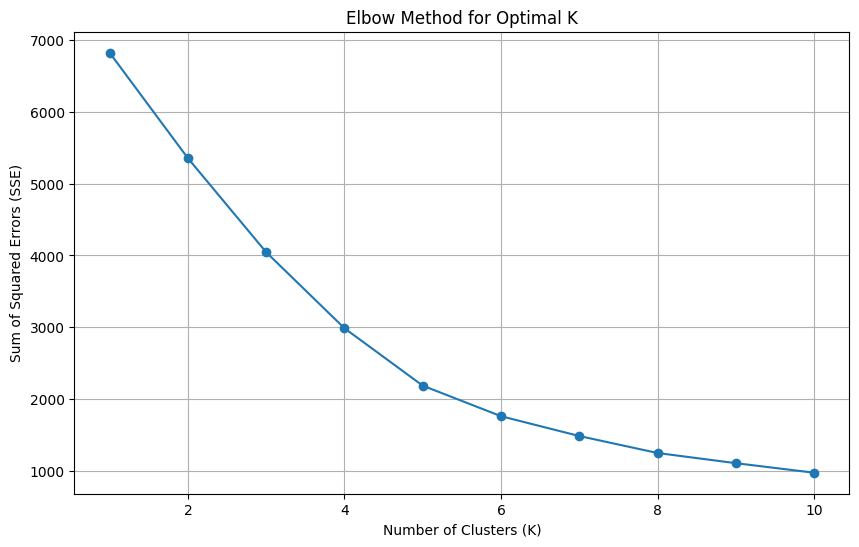

✅ SSE calculated for K=1 to 10.


In [127]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Input data is the array of your three PCs (from the previous step)
X_clusters = principal_components_3

# Calculate SSE for K from 1 to 10
sse = []
max_k = 10
for k in range(1, max_k + 1):
    # Initialize KMeans and ensure reproducibility with random_state
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_clusters)
    # The 'inertia_' attribute is the SSE
    sse.append(kmeans.inertia_)

# --- Visualization ---
# In a Jupyter Notebook or IDE, you would run the following code to see the plot:
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_k + 1), sse, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.grid(True)
plt.show()

print("✅ SSE calculated for K=1 to 10.")
# The plot would appear here, showing the elbow.

<Figure size 1200x1000 with 0 Axes>

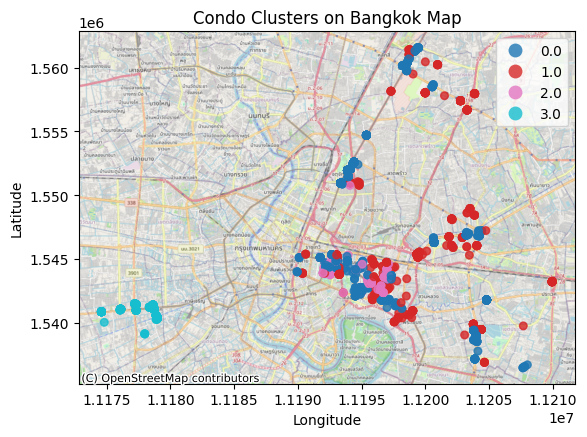

In [128]:
import geopandas as gpd
import contextily as ctx

gdf = gpd.GeoDataFrame(
    df_pca,
    geometry=gpd.points_from_xy(df_pca['longitude'], df_pca['latitude']),
    crs="EPSG:4326",
)
gdf = gdf.to_crs(epsg=3857)

plt.figure(figsize=(12, 10))
ax = gdf.plot(
    ax=None,
    column='Cluster_Label',
    categorical=True,
    legend=True,
    alpha=0.8,
    markersize=30,
)

# use Stamen if available, otherwise fall back to OpenStreetMap
try:
    basemap = ctx.providers.Stamen.TonerLite
except Exception:
    basemap = ctx.providers.OpenStreetMap.Mapnik

ctx.add_basemap(ax, source=basemap)
plt.title('Condo Clusters on Bangkok Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()